In [1]:
import numpy as np
from tifffile import imread, imsave

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from scipy.ndimage.morphology import distance_transform_edt
import itk
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu
from skimage.measure import label
from aicssegmentation.core.visual import blob2dExplorer_single, fila2dExplorer_single, random_colormap
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, suggest_normalization_param, edge_preserving_smoothing_3d

## load one example image

In [2]:
img = imread('./Vanderbilt_colon/000_stack.tif')

In [3]:
img.shape

(10, 4442, 5425)

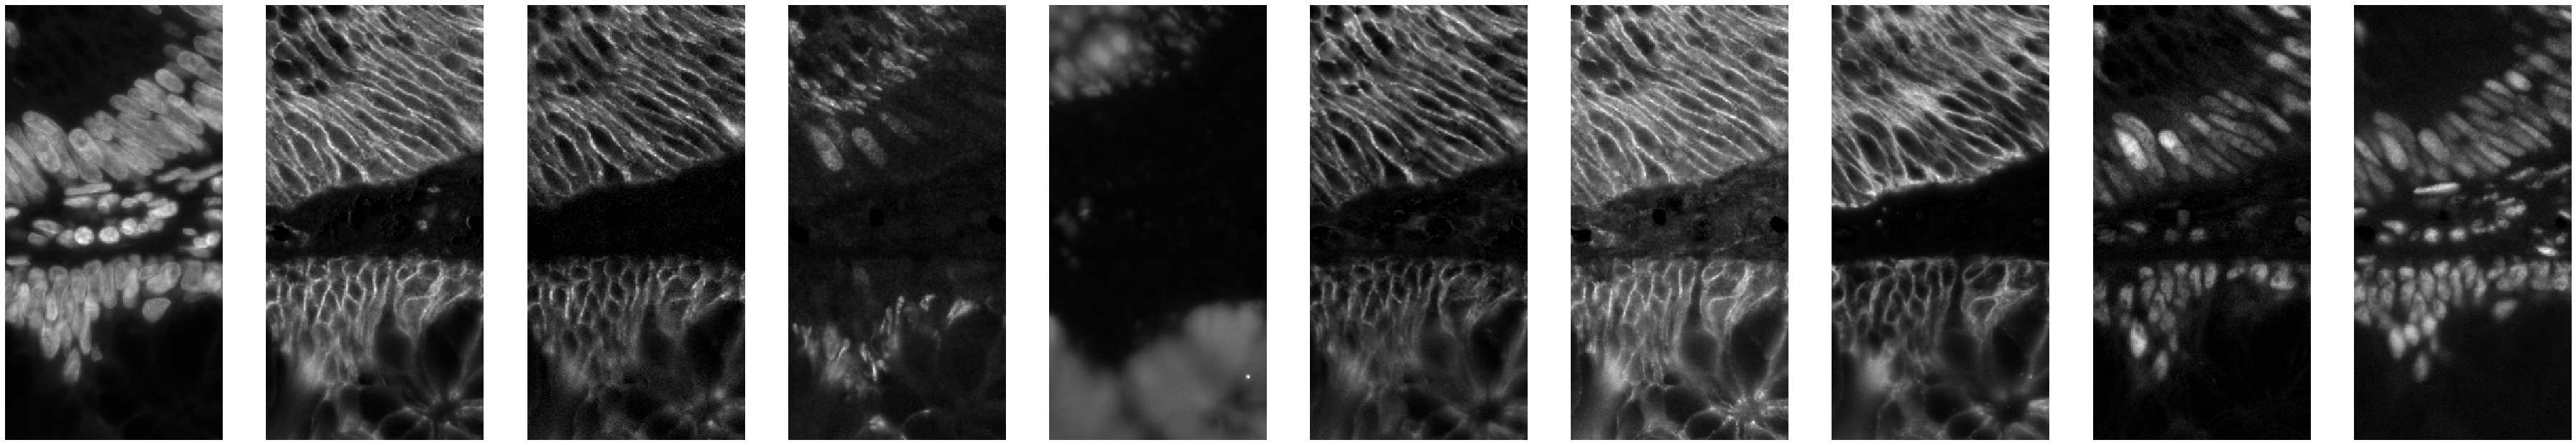

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(64,12))
for jj in range(10):
    ax[jj].axis('off')
    ax[jj].imshow(img[jj,800:1200,1200:1400], cmap=plt.cm.gray)

## crop a small area for algorithm development

In [5]:
img = img[:,800:1200,1200:1400]

## separate two types of info
* channel 1,2,3,5,6,7 could be used for boundary segmentation, we try an average of channel 2 and 6 for demo
* channel 0, 8, 9 could be used for nuclear segmentaiton, we use channel 0 for demo

these channels may be used in totally different ways, here is only a demo

In [6]:
nuc_img = img[9,:,:].copy()
mem_img = (img[2,:,:].copy() + img[6,:,:].copy())/2

## pre-processing: intensity normalization and smoothing

In [7]:
suggest_normalization_param(nuc_img)

mean intensity of the stack: 2581.62485
the standard deviation of intensity of the stack: 2264.8494593377454
0.9999 percentile of the stack intensity is: 13999.044699995618
minimum intensity of the stack: 0
maximum intensity of the stack: 15767
suggested upper range is 5.5, which is 15038.2968763576
suggested lower range is 1.0, which is 316.7753906622547
So, suggested parameter for normalization is [1.0, 5.5]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [8]:
nuc_img_norm = intensity_normalization(nuc_img, [1.0, 3.5])

intensity normalization: normalize into [mean - 1.0 x std, mean + 3.5 x std] 
intensity normalization completes


In [9]:
nuc_img_smooth = edge_preserving_smoothing_3d(nuc_img_norm)

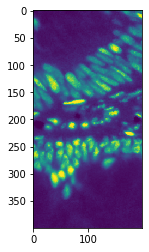

In [10]:
plt.imshow(nuc_img_smooth)

In [11]:
suggest_normalization_param(mem_img)

mean intensity of the stack: 3359.23344375
the standard deviation of intensity of the stack: 1853.0129585862023
0.9999 percentile of the stack intensity is: 10997.506649999348
minimum intensity of the stack: 0.0
maximum intensity of the stack: 12131.5
suggested upper range is 4.5, which is 11697.79175738791
suggested lower range is 1.5, which is 579.7140058706964
So, suggested parameter for normalization is [1.5, 4.5]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [12]:
mem_img_norm = intensity_normalization(mem_img, [1.5, 4.5])

intensity normalization: normalize into [mean - 1.5 x std, mean + 4.5 x std] 
intensity normalization completes


In [13]:
mem_img_smooth = edge_preserving_smoothing_3d(mem_img_norm)

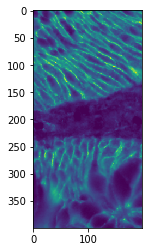

In [14]:
plt.imshow(mem_img_smooth)

## try filament detection

In [15]:
interact(fila2dExplorer_single, im=fixed(mem_img_smooth), \
         sigma=widgets.FloatSlider(value=3, min=1, max=11,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.05,min=0.01, max=0.5, step=0.01,continuous_update=False));

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='sigma', max=11.0, min=1.0, …

# try blob detection

In [16]:
interact(blob2dExplorer_single, im=fixed(nuc_img_smooth), \
         sigma=widgets.FloatRangeSlider(value=(1,5), min=1, max=11,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.02,min=0.01, max=0.1, step=0.01,continuous_update=False));

interactive(children=(FloatRangeSlider(value=(1.0, 5.0), continuous_update=False, description='sigma', max=11.…

## apply the optimal parameters found in previous step

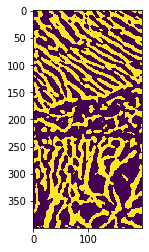

In [17]:
mem_preliminary_mask = filament_2d_wrapper(mem_img_smooth,[[3,0.03]])
plt.imshow(mem_preliminary_mask)

In [18]:
nuc_detection = dot_2d(nuc_img_smooth, 3)

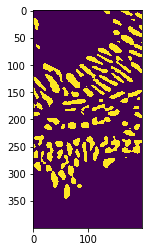

In [19]:
nuc_premask = nuc_detection>0.02
plt.imshow(nuc_premask)

## use the mem to cut the nuc, the results can be used as seeds for watershed

In [20]:
nuc_premask[mem_preliminary_mask>0]=0

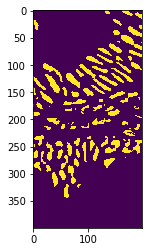

In [21]:
plt.imshow(nuc_premask)

In [22]:
seeds = hole_filling(remove_small_objects(nuc_premask),1, 200)

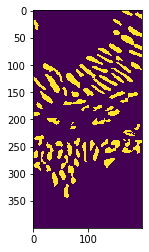

In [23]:
plt.imshow(seeds)

In [24]:
raw_itk = itk.GetImageFromArray(mem_img_smooth.astype(np.float32))
seed_itk= itk.GetImageFromArray(label(seeds).astype(np.int16))
seg_itk = itk.morphological_watershed_from_markers_image_filter(raw_itk, marker_image=seed_itk, fully_connected=True, mark_watershed_line=True)
cell_seg = itk.GetArrayFromImage(seg_itk)

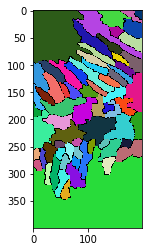

In [25]:
plt.imshow(cell_seg, cmap=random_colormap())

## NOTE: the result above is just a demo of how to use the combination of nuc/mem to identify the boundary of each cell. By understanding more about the data, e.g., which channel marks what subcellular structure, we should be able to device a more meaningful algorithm 